Total rows: 10050
Mean confidence: 0.4042835820895522
Median confidence: 0.35
JUNK rate: 4.2%
High-confidence (>=0.85): 1395 (13.9%)
Medium-confidence (0.5–0.85): 0 (0.0%)
Low-confidence (<0.5): 8655 (86.1%)
Ambiguous (multi-code): 4571 (45.5%)

Confidence distribution:
confidence_bin
(0.0, 0.25]    11.445363
(0.25, 0.5]    74.658831
(0.5, 0.75]     0.000000
(0.75, 1.0]    13.895806
Name: proportion, dtype: float64


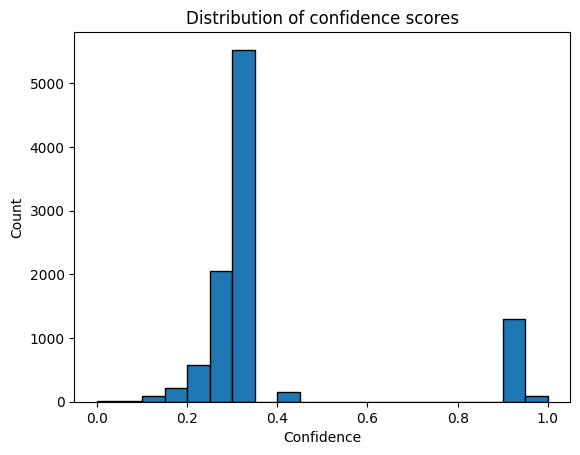

In [1]:
import pandas as pd

# Load output
df = pd.read_csv("output.csv")

# Convert confidence to float
df["confidence"] = df["confidence"].astype(float)

# --- Summary stats ---
print("Total rows:", len(df))
print("Mean confidence:", df["confidence"].mean())
print("Median confidence:", df["confidence"].median())

# JUNK rate
junk_rate = (df["nucc_codes"] == "JUNK").mean()
print(f"JUNK rate: {junk_rate*100:.1f}%")

# High vs low confidence counts
high = (df["confidence"] >= 0.85).sum()
mid  = ((df["confidence"] >= 0.5) & (df["confidence"] < 0.85)).sum()
low  = (df["confidence"] < 0.5).sum()

print(f"High-confidence (>=0.85): {high} ({high/len(df)*100:.1f}%)")
print(f"Medium-confidence (0.5–0.85): {mid} ({mid/len(df)*100:.1f}%)")
print(f"Low-confidence (<0.5): {low} ({low/len(df)*100:.1f}%)")

# Ambiguous mappings (multiple codes)
ambig = df["nucc_codes"].str.contains("\|").sum()
print(f"Ambiguous (multi-code): {ambig} ({ambig/len(df)*100:.1f}%)")

# --- Distribution overview ---
df["confidence_bin"] = pd.cut(df["confidence"], bins=[0,0.25,0.5,0.75,1.0])
print("\nConfidence distribution:")
print(df["confidence_bin"].value_counts(normalize=True).sort_index() * 100)

# --- Optional: plot histogram (if using Jupyter) ---
import matplotlib.pyplot as plt
plt.hist(df["confidence"], bins=20, edgecolor="black")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Distribution of confidence scores")
plt.show()


In [2]:
# Low-confidence or JUNK rows
low_conf_df = df[(df["confidence"] < 0.5) | (df["nucc_codes"] == "JUNK")]
low_conf_df.to_csv("problem_cases.csv", index=False)
print(f"Saved {len(low_conf_df)} low-confidence / junk rows to problem_cases.csv")

# Medium-confidence (borderline) rows
mid_conf_df = df[(df["confidence"] >= 0.5) & (df["confidence"] < 0.85)]
mid_conf_df.to_csv("borderline_cases.csv", index=False)

Saved 8655 low-confidence / junk rows to problem_cases.csv
